In [29]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat

import matplotlib.pyplot as plt  
import seaborn as sb  
%matplotlib inline

Implement an anomaly detection algorithm to detect anomalous behavior in server computers. The features measure the throughput (mb/s) and latency (ms) of response of each server

In [30]:
DATAPATH = '../../datasets/'
data = loadmat(os.path.join(DATAPATH, 'ex8data1.mat'))
pd_data = pd.DataFrame(data['X'], columns=['col1', 'col2'])

In [33]:
pd_data.shape

(307, 2)

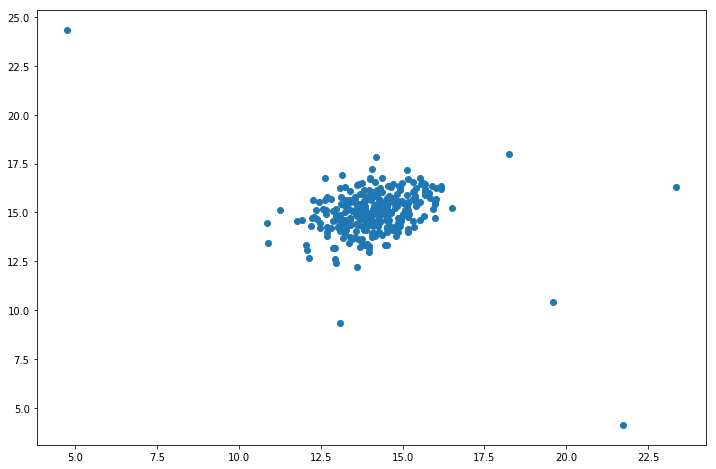

In [12]:
fx, ax = plt.subplots(figsize=(12, 8))
ax.scatter(pd_data.iloc[:,0], pd_data.iloc[:,1])

It appears that there's a pretty tight cluster in the center with several values further out away from the cluster. In this simple example, these could be considered anomalies. To find out, we're tasked with estimating a Gaussian distribution for each feature in the data. You may recall that to define a probability distribution we need two things - mean and variance. To accomplish this we'll create a simple function that calculates the mean and variance for each feature in our data set.

### Gaussian distribution
To perform anomaly detection, you will first need to fit a model to the data’s distribution

In [51]:
def estimate_gaussian(X):
    '''
    This function takes as input the data matrix X and should output an n-dimension vector mu that holds the mean of all the n
    features and another n-dimension vector sigma2 that holds the variances of all the features. 
    '''
    m = len(X)
    #calculate Gaussian Mean (X.mean(axis=0))
    mu = np.sum(pd_data)/m 
    #calculate Gaussian variance (X.var(axis=0))
    var = round(sum((pd_data.iloc[x_i] - mu)**2 for x_i in range(0, len(X)))/ (307-1), 2)
    
    return mu, var
    

In [53]:
mu, var = estimate_gaussian(pd_data)
mu, var

(col1    14.112226
 col2    14.997711
 dtype: float64, col1    1.84
 col2    1.72
 dtype: float64)

Now that you have estimated the Gaussian parameters, you can investigate
which examples have a very high probability given this distribution and which
examples have a very low probability. The low probability examples are
more likely to be the anomalies in our dataset. One way to determine which
examples are anomalies is to select a threshold based on a cross validation
set

In [57]:
## labeled cross validation
Xval = data['Xval']  
yval = data['yval']

Xval.shape, yval.shape  

((307, 2), (307, 1))

We also need a way to calculate the probability that a data point belongs to a normal distribution given some set of parameters. Fortunately SciPy has this built-in.

In [62]:
from scipy import stats  
dist = stats.norm(mu[0], var[0])  
dist.pdf(pd_data.iloc[:,0])[0:50]  

array([ 0.18335327,  0.20152585,  0.21659231,  0.19714657,  0.20782514,
        0.21566573,  0.16956797,  0.15106895,  0.11651436,  0.15923034,
        0.21629511,  0.21673395,  0.20073656,  0.20089118,  0.21624895,
        0.21671718,  0.21609274,  0.21299998,  0.20978316,  0.1174109 ,
        0.20689756,  0.21630889,  0.19449548,  0.21615772,  0.17390476,
        0.15394152,  0.20922022,  0.20154455,  0.2095344 ,  0.2123166 ,
        0.16132618,  0.21621491,  0.17782763,  0.17375861,  0.12653641,
        0.19660174,  0.14527384,  0.21679213,  0.21111057,  0.21642737,
        0.21158025,  0.18746093,  0.21178664,  0.21665782,  0.20543329,
        0.21436151,  0.12803773,  0.21680944,  0.21455519,  0.16879459])

In case it isn't clear, we just calculated the probability that each of the first 50 instances of our data set's first dimension belong to the distribution that we defined earlier by calculating the mean and variance for that dimension. Essentially it's computing how far each instance is from the mean and how that compares to the "typical" distance from the mean for this data.

Let's compute and save the probability density of each of the values in our data set given the Gaussian model parameters we calculated above

In [64]:
p = np.zeros((pd_data.shape[0], pd_data.shape[1]))  
p[:,0] = stats.norm(mu[0], var[0]).pdf(pd_data.iloc[:,0])  
p[:,1] = stats.norm(mu[1], var[1]).pdf(pd_data.iloc[:,1])

p.shape  

(307, 2)

We also need to do this for the validation set (using the same model parameters). We'll use these probabilities combined with the true label to determine the optimal probability threshold to assign data points as anomalies.

In [66]:
pval = np.zeros((Xval.shape[0], Xval.shape[1]))  
pval[:,0] = stats.norm(mu[0], var[0]).pdf(Xval[:,0])  
pval[:,1] = stats.norm(mu[1], var[1]).pdf(Xval[:,1])  

### Selecting the threshold, ε

Next, we need a function that finds the best threshold value given the probability density values and true labels. To do this we'll calculate the F1 score for varying values of epsilon. F1 is a function of the number of true positives, false positives, and false negatives.

In [72]:
def selectThreshold(pval, yval):
    '''
    The function selectThreshold.m should return two values; the first is the selected threshold ε. If an example x has a low probability p(x) < ε,
    then it is considered to be an anomaly. The function should also return the F1 score, which tells you how well you’re doing on finding the ground truth 
    anomalies given a certain threshold
    '''
    best_epsilon = 0
    best_f1 = 0
    f1 = 0

    step = (pval.max() - pval.min()) / 1000

    for epsilon in np.arange(pval.min(), pval.max(), step):
        preds = pval < epsilon

        tp = np.sum(np.logical_and(preds == 1, yval == 1)).astype(float)
        fp = np.sum(np.logical_and(preds == 1, yval == 0)).astype(float)
        fn = np.sum(np.logical_and(preds == 0, yval == 1)).astype(float)

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = (2 * precision * recall) / (precision + recall)

        if f1 > best_f1:
            best_f1 = f1
            best_epsilon = epsilon

    return best_epsilon, best_f1
    

In [73]:
epsilon, f1 = selectThreshold(pval, yval)  
epsilon, f1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


(0.0099735554607736764, 0.7142857142857143)

Finally, we can apply the threshold to the data set and visualize the results.

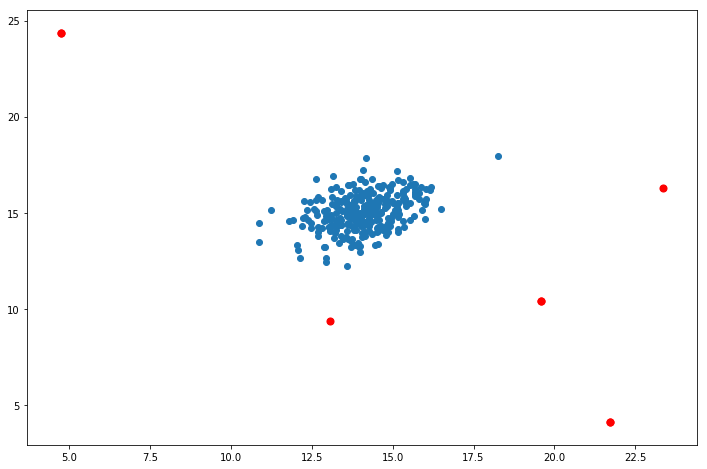

In [78]:
# indexes of the values considered to be outliers
outliers = np.where(p < epsilon)

fig, ax = plt.subplots(figsize=(12,8))  
ax.scatter(pd_data.iloc[:,0], pd_data.iloc[:,1])  
ax.scatter(pd_data.iloc[outliers[0],0], pd_data.iloc[outliers[0],1], s=50, color='r', marker='o') 

Not bad! The points in red are the ones that were flagged as outliers. Visually these seem pretty reasonable. The top right point that has some separation (but was not flagged) may be an outlier too, but it's fairly close.

In [82]:
#Multi Dimensional data

data_mul = loadmat(os.path.join(DATAPATH, 'ex8data2.mat'))
pd_data_mul = pd.DataFrame(data_mul['X'], columns=['col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7', 'col8', 'col9', 'col10', 'col11'])

In [83]:
pd_data_mul.shape

(1000, 11)